<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Walk_on_Boundary_and_BIEM/WalkOnBoundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
from jax import lax
from jax import random

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
'''
signed distance function of the domain
'''
@jax.jit
def signDistance(p):
  return jnp.linalg.norm(p,ord=2,axis=0) - 1 # unit sphere

In [3]:
'''
bounding box diameter
'''
@jax.jit
def box():
  return 2

In [4]:
'''
Dirchlet boundary condition
'''
@jax.jit
def boundaryCond(p):
  return p[1]

In [5]:
'''
binary search to find boundary intersection
'''
@jax.jit
def binaryRootSearch(p0, p1, epochs, dir):
  p1 = p0 + p1 # need to center p1 at p0

  current = jnp.zeros((jnp.size(p0, 1), jnp.size(p0, 2)))

  def binaryStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist = signDistance(p0 + dir * next * (p1 - p0))
    return jnp.where(dist > 0, current, next)

  current = lax.fori_loop(0, epochs, binaryStep, current)
  
  return p0 + dir * current * (p1 - p0), current # return the roots, t-values

In [6]:
'''
run the wob and calculate the estimator
'''
@jax.jit
def wob(p0, p1, t, epochs):
  '''
  pFirst, tFirst = binaryRootSearch(p0, p1[0], epochs, 1)
  def wobStep(i, next):
    est = next[1] + 2 * jnp.power(-1,i+1) * boundaryCond(next[0])

    pBack, tBack = binaryRootSearch(next[0], p1[i], epochs, -1)
    pFor, tFor = binaryRootSearch(next[0], p1[i], epochs, 1)
    pNext = jnp.where(tBack > tFor, pBack, pFor)
    return (pNext, est)

  est = jnp.zeros((jnp.size(p1,2),jnp.size(p1, 3)))
  pLast, est = lax.fori_loop(1, t, wobStep, (pFirst, est))
  return est + jnp.power(-1, t+1) * boundaryCond(pLast)
  '''
  runningEst = jnp.zeros((jnp.size(p0,1),jnp.size(p0,2)))
  runningSign = 1

  pNext, tFirst = binaryRootSearch(p0, p1[0], epochs, 1)

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext)
    runningSign *= -1
    pBack, tBack = binaryRootSearch(pNext, p, epochs, -1)
    pFor, tFor = binaryRootSearch(pNext, p, epochs, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext)
  return runningEst

In [7]:
'''
setup the wob
'''
def computeSoln(t, epochs, batches, p, key):
  p = p.transpose()
  p = jnp.reshape(p, (jnp.size(p,0), jnp.size(p,1), 1))
  p0 = jnp.tile(p, (1,1,batches))

  # generate random directions in n-dimensions
  p1 = random.normal(key, shape=(t, jnp.size(p, 0), jnp.size(p, 1), batches))
  normalize = jnp.linalg.norm(p1, ord=2, axis=1, keepdims=True)
  p1 = box() * jnp.divide(p1, normalize)

  ans = wob(p0, p1, t, epochs)
  return jnp.mean(ans, 1, keepdims=True)

In [27]:
%%time
'''
testing code
'''
key = random.PRNGKey(int(time.time()))
x = jnp.array([[0.5,0,0.2],[0,0.15,0.7]])

y = computeSoln(4, 15, 100000, x, key)
print('solution:', y)

solution: [[0.00017896]
 [0.1526427 ]]
CPU times: user 261 ms, sys: 5.64 ms, total: 267 ms
Wall time: 190 ms


In [8]:
'''
generate dataset with throw-out algorithm
WARNING: this algorithm gets worse in higher dimensions
'''
key = random.PRNGKey(1)
dimensions = 3
samples = 100
x = random.uniform(key, minval=-box()/2, maxval=box()-box()/2, shape=(samples,dimensions))
indices = jnp.where(signDistance(x.transpose()) < 0)
print('kept', len(x[indices]), 'out of', len(x))
x = x[indices]

#print(x)
#print('solution:', y)

kept 50 out of 100


In [11]:
%%time
y = computeSoln(4, 15, 100000, x, key)

CPU times: user 115 ms, sys: 936 µs, total: 116 ms
Wall time: 117 ms


In [ ]:
'''
save the dataset
'''
data = jnp.concatenate((y,x), axis=1)
df = pd.DataFrame(data)
print(df)
df.to_pickle('wobDataset.pkl')

             0    1     2    3
0  0.009437477  0.5   0.0  0.2
1    0.1464047  0.0  0.15  0.7


In [ ]:
'''
download the dataset
'''
df = pd.read_pickle('wobDataset.pkl')
y = df.iloc[:,0].to_numpy() # [u0, u1, ..., un]
x = df.iloc[:,1:].to_numpy() # [p0, p1, ..., pn]

[ 0.60365611 -0.38852304  0.07902981  0.27081057  0.29596221  0.29300246]
CPU times: user 17.2 s, sys: 505 ms, total: 17.7 s
Wall time: 16.9 s


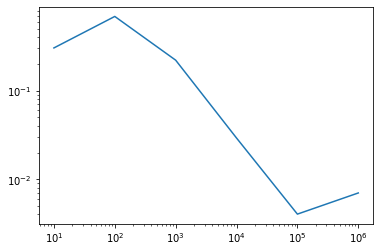

In [ ]:
'''
plot the data
'''
t = 10 # number of jumps on the boundary
epochs = 25 # binary search time steps
batches = jnp.power(10,np.arange(1,7))
y = jnp.array([[0.5,0.3]]).transpose()

key = random.PRNGKey(int(time.time()))
keys = random.split(key, len(batches))

values = np.zeros(len(batches))
for i in range(len(batches)):
  values[i] = computeSoln(t, epochs, batches[i], y, keys[i])[0]

print(values)
error = np.abs(values - 0.3)
plt.plot(batches, error)
plt.xscale('log')
plt.yscale('log')